# Kaggle Learn: Computer Vision

In this notebook, we teach a computer to see! We will be introduced to the fundamental ideas of computer vision. Our goal is to learn how a neural network can "understand" a natural image well-enough to solve the same kinds of problems the human visual system can solve.

The neural networks that are best at this task are called **convolutional neural networks** (Sometimes we say *convnet* or *CNN* instead.) **Convolution** is the mathematical operation that gives the layers of a convnet their unique structure.

We will apply these ideas to the problem of image classification: given a picture, can we train a computer to tell us what it's a picture of? For example, apps that can identify a species of plant from a photograph are image classifiers!

## Table Of Contents

* **0.** [Dependancies and Settings](#0-Dependancies-and-Settings)  
* **1.** [Useful Links](#1-Useful-Links)  
* **2.** [The Convolutional Classifier](#2-The-Convolutional-Classifier)  
  * **2.1.** [Training a Covnet Classifier](#2.1-Training-a-Covnet-Classifier)  
* **3.** [Feature Extraction](#3-Feature-Extraction)  
  * **3.1.** [Filter with convolution](#3.1-Filter-with-convolution)  
  * **3.2.** [Detect with ReLU](#3.2-Detect-with-ReLU)  
  * **3.3.** [Manual example](#3.3-Manual-example)  
* **4.** [Pooling](#4-Pooling)  
  * **4.1.** [Maximum pooling](#4.1-Maximum-pooling)  
  * **4.2.** [Translation invariance](#4.2-Translation-invariance)  
  * **4.3.** [Global Average Pooling](#4.3-Global-Average-Pooling)  

## 0 Dependancies and Settings

Installation:

In [1]:
# Installing or upgrading
# Note: might have to restart kernel

# Uncomment:
# import sys

# Installing:
# !{sys.executable} -m pip install scikit-learn
# Upgrading:
# !{sys.executable} -m pip install --upgrade scipy==1.9.0 --user

Imports:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn

In [3]:
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)
print('tensorflow version:', tf.__version__)
print('sci-kit learn version:', sklearn.__version__)

pandas version: 1.5.2
numpy version: 1.23.0
tensorflow version: 2.11.0
sci-kit learn version: 1.2.0


Set the plotting style:

In [4]:
try:
    scientific_style = [
        '../../Random/PythonTutorialsForDataScience/data/science.mplstyle', 
        '../../Random/PythonTutorialsForDataScience/data/notebook.mplstyle', 
        '../../Random/PythonTutorialsForDataScience/data/grid.mplstyle'
    ]

    plt.style.use(scientific_style)
    
    print('Using Scientific Style.')
except:
    print('Missing Scientific Style, continuing with default.')

Using Scientific Style.


Define the filepath where most of the data resides:

In [5]:
path = r'C:\Users\seani\Documents\JupyterNotebooks\Kaggle\KaggleLearn\Assets'

Function used to get names of files in a directory:

In [6]:
import os

def get_files(path):
    '''
    Inputs: a path string
    Returns: a list of names of files in a directory
    '''
    
    files = []
    # search through each item in the directory
    for file in os.listdir(path):
        # check it is a file
        if os.path.isfile(os.path.join(path, file)):
            files.append(file)
    
    return files

The seed used throughout for reproducable randomness:

In [7]:
seed = 1

## 1 Useful Links

- Tensorflow main page: https://www.tensorflow.org/  
- Tensorflow python API: https://www.tensorflow.org/api_docs/python/tf  

## 2 The Convolutional Classifier

A convnet used for image classification consists of two parts: a convolutional **base** and a dense **head**. 

The **base** is used to extract the features from an image. It is formed primarily of layers performing the convolution operation, but often includes other kinds of layers as well. (You'll learn about these in the next lesson.)

The **head** is used to determine the class of the image. It is formed primarily of dense layers, but might include other layers like dropout.

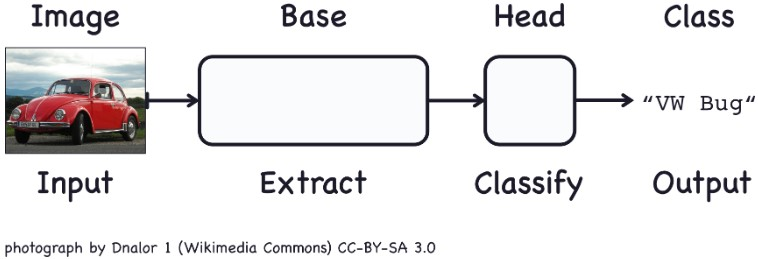

*Figure 1: The Image input is passed through the base and head where features are extracted and classified respectively. These classifications are then used to reach a prediction (output).*

What do we mean by visual **feature**? A feature could be a line, a color, a texture, a shape, a pattern - or some complicated combination.

The whole process goes something like this:

*Note: The features actually extracted look a bit different, but it gives the idea.*

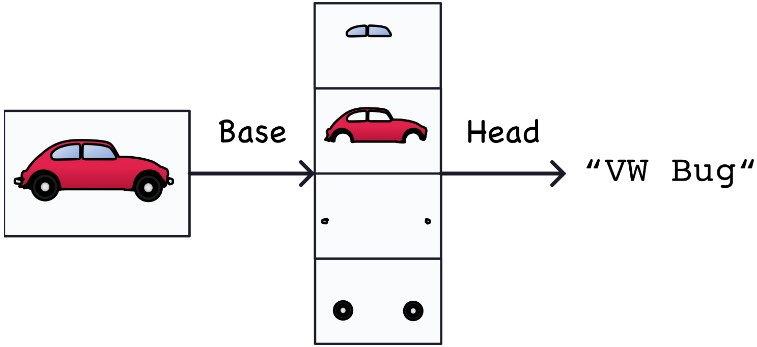

*Figure 2: After the image is passed through the base, it is split into its respective features. After passing through the head, these are classified and a prediction is made.*

The goal of the network during training is to learn two things:

1. Which features to extract from an image (base),
2. Which class goes with what features (head).

These days, convnets are rarely trained from scratch. More often, we reuse the base of a **pretrained model**. To the pretrained base we then attach an untrained head. In other words, we reuse the part of a network that has already learned to extract features (1.), and attach to it some fresh layers to learn classification (2.).

Reusing a pretrained model is a technique known as **transfer learning**. It is so effective, that almost every image classifier these days will make use of it.

### 2.1 Training a Covnet Classifier

Throughout this notebook, we're going to be creating classifiers that attempt to solve the following problem: *is this a picture of a Car or of a Truck?* Our [dataset](https://www.kaggle.com/datasets/ryanholbrook/car-or-truck) is about 10,000 pictures of various automobiles, around half cars and half trucks.

This following cell will import some libraries and set up our data pipeline. We have a training split called ``ds_train`` and a validation split called ``ds_valid``.

In [8]:
# imports
import os, warnings
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory

warnings.filterwarnings("ignore") # to clean up output cells

# reproducability
np.random.seed(seed)
tf.random.set_seed(seed)

# load training and validation sets
ds_train_ = image_dataset_from_directory(
    'Assets/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'Assets/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_train

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

The most commonly used dataset for pretraining is [ImageNet](https://www.image-net.org/download.php), a large dataset of many kind of natural images. Keras includes a variety models pretrained on ImageNet in its [``applications`` module](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

One of the bases we can use is from a model called **VGG16**. However, we would see that the VGG16 architecture is prone to overfitting this dataset. Over this notebook, we'll learn a number of ways we can improve upon this initial attempt.

The first way we'll see is to use a base more appropriate to the dataset. The base this model comes from is called **InceptionV1** (also known as GoogLeNet). InceptionV1 was one of the early winners of the ImageNet competition. One of its successors, InceptionV4, is among the state of the art today.

The InceptionV1 model pretrained on ImageNet is available in the [TensorFlow Hub repository](https://www.tensorflow.org/hub/), but we'll load it from a local copy:

*Note: when doing transfer learning, it's generally not a good idea to retrain the entire base - at least not without some care. The reason is that the random weights in the head will initially create large gradient updates, which propogate back into the base layers and destroy much of the pretraining. Using techniques known as **fine tuning** it's possible to further train the base on new data, but this requires some care to do well.*

In [9]:
pretrained_base = tf.keras.models.load_model(
    'models/inceptionv1'
)

pretrained_base.trainable = False

pretrained_base

Next, we attach the classifier head. For this example, we'll use a layer of hidden units (the first Dense layer) followed by a layer to transform the outputs to a probability score for class 1, Truck. The Flatten layer transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Base
    pretrained_base,
    layers.Flatten(),  # flatten outputs of base
    # Head
    layers.Dense(units=6, activation='relu'),
    # Output
    layers.Dense(units=1, activation='sigmoid'),
])

Finally, let's train the model. Since this is a two-class problem, we'll use the **binary** versions of ``crossentropy`` and ``accuracy``. The ``adam`` optimizer generally performs well, so we'll choose it as well:

In [ ]:
# create optimizer
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

# compile model
model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
)

We can use Pandas to convert this dictionary to a dataframe and plot it with a built-in method:

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

The training loss and validation loss stay fairly close, this is evidence that the model isn't just memorizing the training data but rather learning general properties of the two classes. However, because this model converges at a loss greater than the VGG16 model (test for yourself), it's likely that it is underfitting some, and could benefit from some extra capacity.

## 3 Feature Extraction

In this section, we're going to learn about one of the two most important types of layers that you'll usually find in the **base** of a convolutional image classifier. This is the **convolutional layer with ReLU activation** (the other layer is the **maximum pooling layer**, discussed later).

Before we get into the details of convolution, let's discuss the purpose of these layers in the network. We're going to see how these three operations (convolution, ReLU, and maximum pooling) are used to implement the feature extraction process:

1. Filter an image for a particular feature (convolution)
2. Detect that feature within the filtered image (ReLU)
3. Condense the image to enhance the features (maximum pooling)

The next figure illustrates this process. You can see how these three operations are able to isolate some particular characteristic of the original image (in this case, horizontal lines):

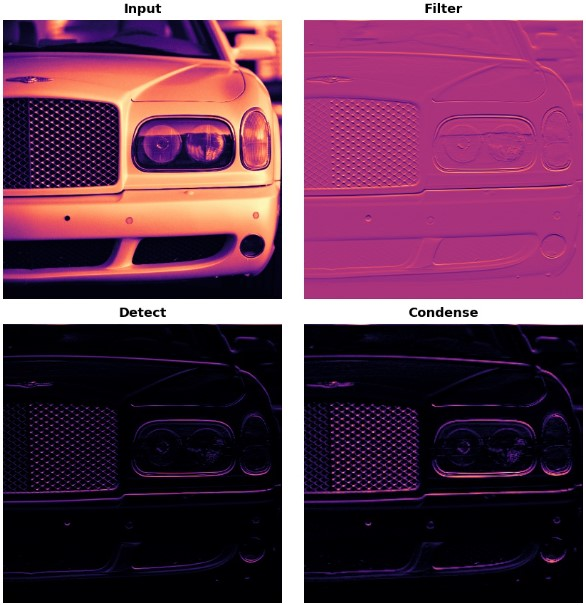

*Figure 3: The three steps of feature extraction acting upon the input image. Notice how convolution filters the image for the features, ReLU allows detection of desired features, and maximum pooling enhances these.*

Typically, the network will perform several extractions in parallel on a single image. In modern convnets, it's not uncommon for the final layer in the base to be producing over 1000 unique visual features.

### 3.1 Filter with convolution

A convolutional layer carries out the filtering step. You might define a convolutional layer in a Keras model something like the following cell. We can understand these parameters by looking at their relationship to the weights and activations of the layer:

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    # More layers follow
])

The **weights** a convnet learns during training are primarily contained in its convolutional layers. These weights we call kernels. We can represent them as small arrays. The following are examples of kernels (with their effects):

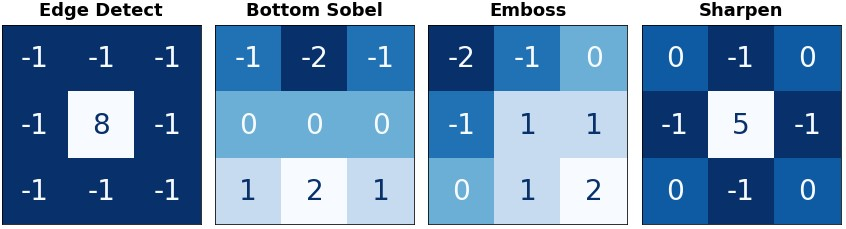

*Figure 4: Examples of kernels with the effects they have on the image.*

A kernel operates by scanning over an image and producing a weighted sum of pixel values. In this way, a kernel will act sort of like a polarized lens, emphasizing or deemphasizing certain patterns of information.

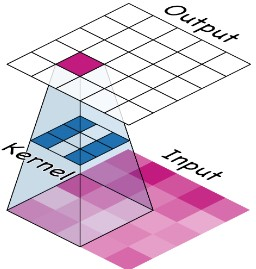

*Figure 5: The kernel is acted upon each pixel one after another. Each cell in the kernel has a value and hovers over a pixel, which also has a value (think RGB or grayscale), these values are multiplied and added with the other mulitplied values from other pixels and cells. The result is then the value of the pixel in the middle.*

Kernels define how a convolutional layer is connected to the layer that follows. The kernel above will connect each neuron in the output to nine neurons in the input. By setting the dimensions of the kernels with kernel_size, you are telling the convnet how to form these connections. Most often, a kernel will have odd-numbered dimensions -- like kernel_size=(3, 3) or (5, 5) -- so that a single pixel sits at the center, but this is not a requirement.

The kernels in a convolutional layer determine what kinds of features it creates. During training, a convnet tries to learn what features it needs to solve the classification problem. This means finding the best values for its kernels.

See the *But what is a convolution?* video by **3blue1brown** for further explanation: https://www.youtube.com/watch?v=KuXjwB4LzSA&t=891s&ab_channel=3Blue1Brown

*Note: typically in maths you flip the kernal around before applying it, and computer science not so. This varies from application to application.*

Feature maps what result when we apply a filter to an image; they contain the visual features the kernel extracts. Here are a few kernels pictured with feature maps they produced:

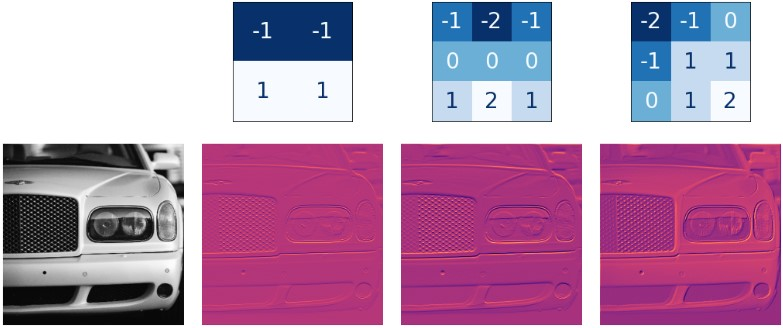

*Figure 6: The input image with different kernels acted upon it.*

From the pattern of numbers in the kernel, you can tell the kinds of feature maps it creates. Generally, what a convolution accentuates in its inputs will match the shape of the *positive* numbers in the kernel (again this may differ from the maths way of doing it). The left and middle kernels above will both filter for horizontal shapes.

With the ``filters`` parameter, you tell the convolutional layer how many feature maps you want it to create as output.

### 3.2 Detect with ReLU

Recall the ReLU activation function:

Text(0.5, 1.0, 'ReLU activation function')

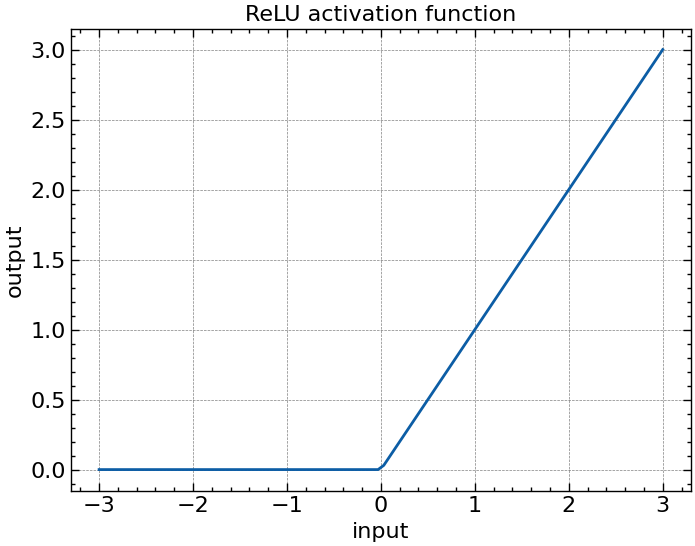

In [12]:
x = np.linspace(-3, 3, 100)
y = np.maximum(0, x)
plt.plot(x, y)
plt.xlabel('input')
plt.ylabel('output')
plt.title('ReLU activation function')

The ReLU activation can be defined in its own ``Activation`` layer, but most often you'll just include it as the activation function of ``Conv2D``:

In [13]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu')
    # More layers follow
])

You could think about the activation function as scoring pixel values according to some measure of importance. The ReLU activation says that negative values are not important and so sets them to 0. ("Everything unimportant is equally unimportant.")

Here is ReLU applied the feature maps above. Notice how it succeeds at isolating the features:

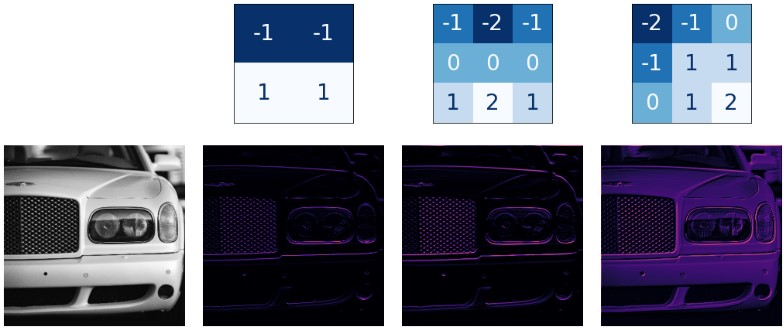

*Figure 7: Same as Figure 6 but now with ReLU applied. Notice how the desired features are now detected and isolated.*

### 3.3 Manual example

Let's now perform these on an example image. The image has been taken from the *Car or Truck?* dataset:

(-0.5, 399.5, 399.5, -0.5)

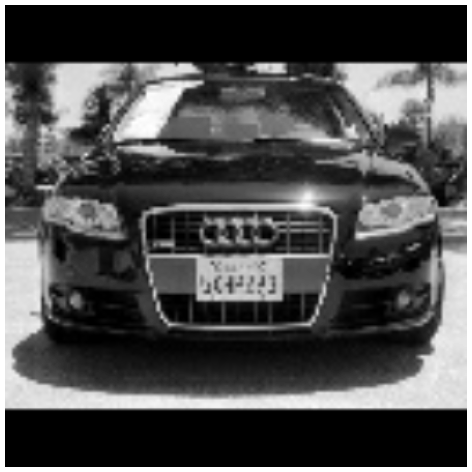

In [14]:
# get path to image
image_path = 'Assets/car-or-truck/train/Car/00268.jpeg'
# read it and preprocess
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])  # resize for readability

# plot with matplotlib
img = tf.squeeze(image).numpy()
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.axis('off')

Now let's define the kernel to use. One thing to keep in mind is that the sum of the numbers in the kernel determines how bright the final image is. Generally, you should try to keep the sum of the numbers between 0 and 1 (though that's not required).

In general, a kernel can have any number of rows and columns. For this exercise, let's use a $3 \times 3$ kernel, which often gives the best results. We define a kernel with ``tf.constant``, the following kernel should preserve vertical features on the right:

In [15]:
kernel = tf.constant([
    [-0.25, 0, 0.25],
    [-0.25, 0, 0.25],
    [-0.25, 0, 0.25],
])

Now we must first perform some preprocessing before applying these:

In [16]:
# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # converts pixel values to floats
image = tf.expand_dims(image, axis=0)  # adds an extra dimension
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])  # reshapes kernel to necessary shape
kernel = tf.cast(kernel, dtype=tf.float32)  # converts kernel to floats

Instead of using the keras layer for the convolution, we will use the tensorflow backend function that performs the same operation, `tf.nn.conv2d()`:

*Note: the `strides` and `padding` arguments will be explained later.*

(-0.5, 399.5, 399.5, -0.5)

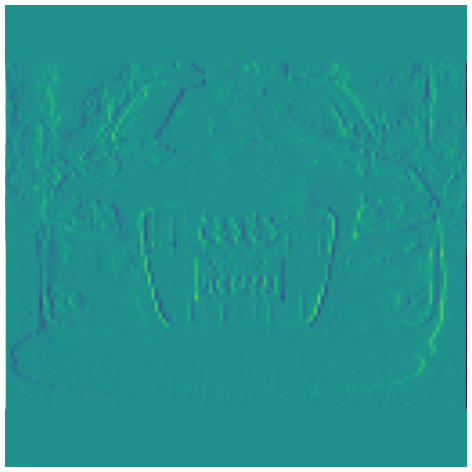

In [17]:
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1, # or (1, 1)
    padding='SAME',
)

plt.imshow(
    # Reformat for plotting
    tf.squeeze(image_filter)
)
plt.axis('off')

Now let's apply the ReLU function. There is also a tensorflow backend function, `tf.nn.relu()`:

(-0.5, 399.5, 399.5, -0.5)

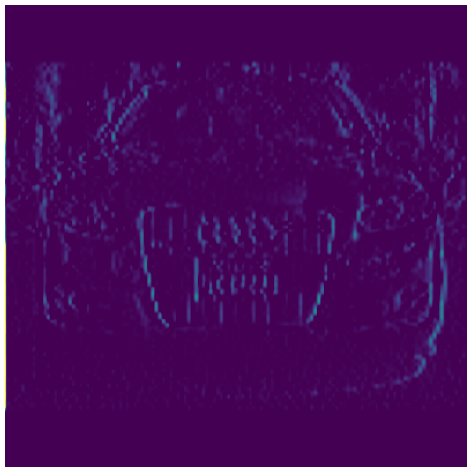

In [18]:
image_detect = tf.nn.relu(image_filter)

plt.imshow(
    # Reformat for plotting
    tf.squeeze(image_detect)
)
plt.axis('off')

Notice the vertical features on the right edge have been isolated.

It can also be useful to see how these operations act on an array, to really see how they affect the input:

In [19]:
image = np.array([
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 1],
    [0, 1, 0, 0, 0, 0],
])

kernel = np.array([
    [1, -1],
    [1, -1],
])

print('Input array:')
display(image)
print('Kernel:')
display(kernel)

# Reformat for Tensorflow
image = tf.cast(image, dtype=tf.float32)
image = tf.reshape(image, [1, *image.shape, 1])
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='VALID',
)
image_detect = tf.nn.relu(image_filter)

# The first matrix is the image after convolution, and the second is
# the image after ReLU.
print('After convolution:')
display(tf.squeeze(image_filter).numpy())
print('After ReLU:')
display(tf.squeeze(image_detect).numpy())

Input array:


array([[0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0]])

Kernel:


array([[ 1, -1],
       [ 1, -1]])

After convolution:


array([[-2.,  2.,  0.,  0.,  0.],
       [-2.,  2.,  0.,  0.,  0.],
       [-2.,  2.,  0.,  0.,  0.],
       [-2.,  2., -1.,  0.,  0.],
       [-2.,  2., -1.,  0.,  0.]], dtype=float32)

After ReLU:


array([[0., 2., 0., 0., 0.],
       [0., 2., 0., 0., 0.],
       [0., 2., 0., 0., 0.],
       [0., 2., 0., 0., 0.],
       [0., 2., 0., 0., 0.]], dtype=float32)

Notice how only the vertical line was preserved.

## 4 Pooling

In this section, we'll look at the third (and final) operation in the sequence: **condense** with **maximum pooling**, which in Keras is done by a ``MaxPool2D`` layer. We will also look at something called **global average pooling**, which allows us to further condense reduce the number of parameters in the model, it is still widely used in the head of a convnet.

### 4.1 Maximum pooling

Adding condensing step to the model we had before, will give us this:

In [20]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    layers.MaxPool2D(pool_size=2),
    # More layers follow
])

A ``MaxPool2D`` layer is much like a ``Conv2D`` layer, except that it uses a simple maximum function instead of a kernel, with the ``pool_size`` parameter analogous to ``kernel_size``. A ``MaxPool2D`` layer doesn't have any trainable weights like a convolutional layer does in its kernel, however.

Let's take another look at the extraction figure from the last section, Figure $3$. Remember that ``MaxPool2D`` is the Condense step. Notice that after applying the ReLU function (Detect) the feature map ends up with a lot of "dead space," that is, large areas containing only 0's (the black areas in the image). Having to carry these 0 activations through the entire network would increase the size of the model without adding much useful information. Instead, we would like to condense the feature map to retain only the most useful part - the feature itself.

This in fact is what maximum pooling does. Max pooling takes a patch of activations in the original feature map and replaces them with the maximum activation in that patch.

*Note, from ChatGPT: The feature maps represent the activations (outputs) of the previous layer, typically a convolutional layer. These activations are the result of applying a set of filters to the input image, and they represent the features of the image at different levels of abstraction.*

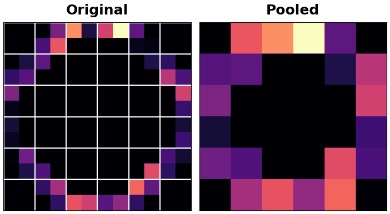

*Figure 8: An example of maximum pooling acted on a feature map. Notice how the Original is split into larger cells, the maximum value in each cell is taken as the value for the whole cell. Although this loses some complexity, it greatly condenses the feature map and thus reduces the number of parameters we have to keep track of.*

When applied after the ReLU activation, it has the effect of "intensifying" features. The pooling step increases the proportion of active pixels to zero pixels, and thus condenses the feature map.

Let's examine this with the picture above. The following code gets us back on track:

In [31]:
# get path to image
image_path = 'Assets/car-or-truck/train/Car/00268.jpeg'
# read it and preprocess
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])  # resize for readability

# Define kernel
kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
], dtype=tf.float32)

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])

# Filter step
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # we'll talk about these two in the next section
    strides=1,
    padding='SAME'
)

# Detect step
image_detect = tf.nn.relu(image_filter)

We can use the tensorflow backend function for the `MaxPool2D` layer, the `tf.nn.pool()` function:

In [32]:
image_condense = tf.nn.pool(
    input=image_detect, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # we'll see what these do in the next lesson!
    strides=(2, 2),
    padding='SAME',
)

Finally, we can show each operation to compare:

Text(0.5, 1.0, 'Condense (MaxPool)')

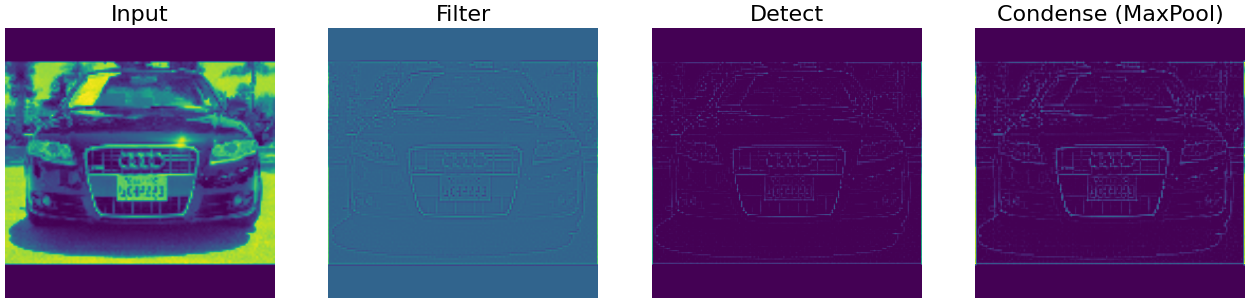

In [33]:
# Show what we have so far
plt.figure(figsize=(16, 6))
plt.subplot(141)
plt.imshow(tf.squeeze(image))
plt.axis('off')
plt.title('Input')
plt.subplot(142)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(143)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.subplot(144)
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.title('Condense (MaxPool)')

Notice how the **Condense** layer further intensified the features.

### 4.2 Translation invariance

We called the zero-pixels "unimportant". Does this mean they carry no information at all? In fact, the zero-pixels carry positional information. The blank space still positions the feature within the image. When ``MaxPool2D`` removes some of these pixels, it removes some of the positional information in the feature map. This gives a convnet a property called **translation invariance**. This means that a convnet with maximum pooling will tend not to distinguish features by their location in the image.

Watch what happens when we repeatedly apply maximum pooling to the following feature map:

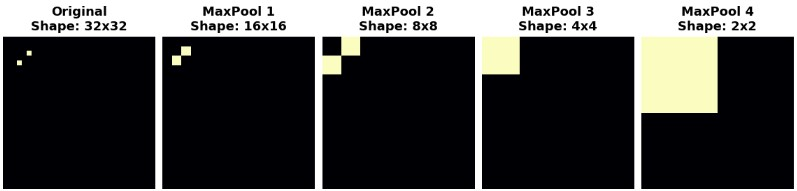

*Figure 9: Maxpooling results in the two dots becoming indistinguishable, positional information has been lost.*

The two dots in the original image became indistinguishable after repeated pooling. In other words, pooling destroyed some of their positional information. Since the network can no longer distinguish between them in the feature maps, it can't distinguish them in the original image either: it has become invariant to that difference in position.

However, pooling only creates translation invariance in a network over small distances, as with the two dots in the image. Features that begin far apart will remain distinct after pooling; only some of the positional information was lost, but not all of it:

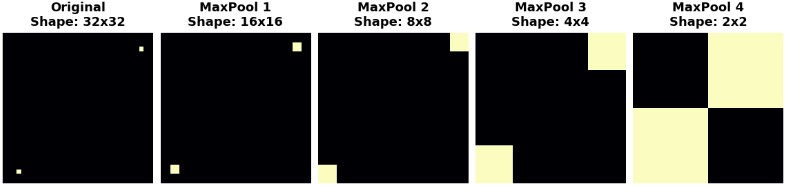

*Figure 10: Although some positional information can be lost as seen in Figure 9, not all is. The two dots are far enough apart that after maxpooling they are still distinguishable.*

This invariance to small differences in the positions of features is a nice property for an image classifier to have. Just because of differences in perspective or framing, the same kind of feature might be positioned in various parts of the original image, but we would still like for the classifier to recognize that they are the same. Because this invariance is built into the network, we can get away with using much less data for training: we no longer have to teach it to ignore that difference. This gives convolutional networks a big efficiency advantage over a network with only dense layers.

For example, consider a feature map in the shape of a circle. The idea is that the final image in the following figure ("MaxPool 4") would remain the same whether the circle was shifted further to the left, or further upwards, etc:

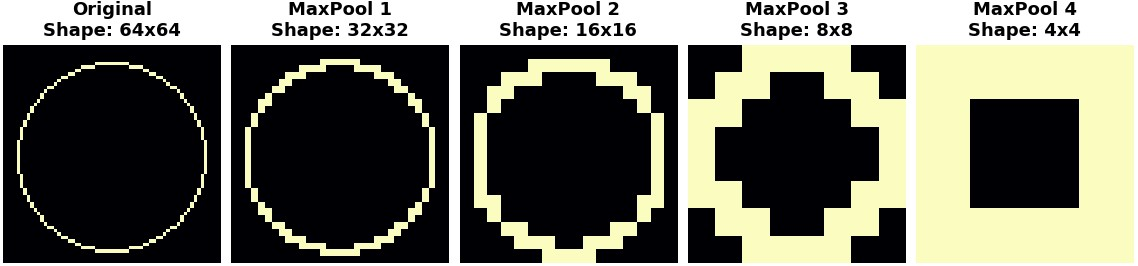

*Figure 11: Maxpooling causes the circle to be reduced to such a fixed shape that even if it was shifted around the image it would remain the same. So we remove positional information (disadvantage), however this allows us to condense the feature map (advantage).*

### 4.3 Global Average Pooling

We mentioned in the previous exercise that average pooling has largely been superceeded by maximum pooling within the convolutional base. There is, however, a kind of average pooling that is still widely used in the **head** of a convnet. This is **global average pooling**. A ``GlobalAvgPool2D`` layer is often used as an alternative to some or all of the hidden Dense layers in the head of the network, like so:

In [34]:
model = keras.Sequential([
    pretrained_base,
    layers.GlobalAvgPool2D(),
    layers.Dense(1, activation='sigmoid'),
])

What is this layer doing? Notice that we no longer have the ``Flatten`` layer that usually comes after the base to transform the 2D feature data to 1D data needed by the classifier. Now the ``GlobalAvgPool2D`` layer is serving this function. But, instead of "unstacking" the feature (like ``Flatten``), it simply replaces the entire feature map with its average value. Though very destructive, it often works quite well and has the advantage of reducing the number of parameters in the model.

Let's look at what ``GlobalAvgPool2D`` does on some randomly generated feature maps. This will help us to understand how it can "flatten" the stack of feature maps produced by the base:

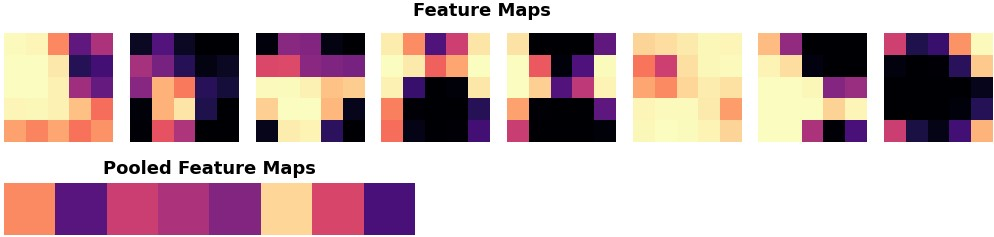

*Figure 12: The feature maps (top) are pooled (bottom). Each cell of the pooled feature maps is the average of all the values of the corresponding feature map.*

Since each of the $5 \times 5$ feature maps was reduced to a single value, global pooling reduced the number of parameters needed to represent these features by a factor of $25$ - a substantial savings!

Now we'll move on to understanding the pooled features. After we've pooled the features into just a single value, does the head still have enough information to determine a class? Let's pass some images from our *Car or Truck* dataset through VGG16 and examine the features that result after pooling. First we define the model and load the dataset:

In [41]:
# get the pretrained base
pretrained_base = tf.keras.models.load_model(
    'models/vgg16'
)

pretrained_base.trainable = False

# define the model
model = keras.Sequential([
    pretrained_base,
    # Attach a global average pooling layer after the base
    layers.GlobalAvgPool2D(),
])

# load training and validation sets
ds = image_dataset_from_directory(
    'Assets/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=1,
    shuffle=True,
)

ds_iter = iter(ds)  # allows us to iterate through the set

Found 5117 files belonging to 2 classes.


Notice how we've attached a ``GlobalAvgPool2D`` layer after the pretrained VGG16 base. Ordinarily, VGG16 will produce $512$ feature maps for each image. The ``GlobalAvgPool2D`` layer reduces each of these to a single value, an "average pixel", if you like.

This next cell will run an image from the *Car or Truck* dataset through VGG16 and show you the $512$ average pixels created by ``GlobalAvgPool2D``. Run the cell a few times and observe the pixels produced by cars versus the pixels produced by trucks.

(-0.5, 31.5, 15.5, -0.5)

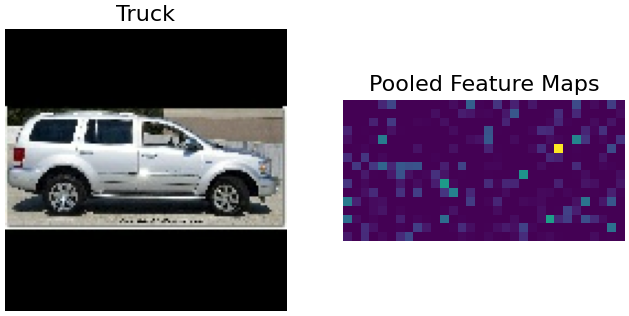

In [44]:
car = next(ds_iter)

car_tf = tf.image.resize(car[0], size=[128, 128])
car_features = model(car_tf)
car_features = tf.reshape(car_features, shape=(16, 32))
label = int(tf.squeeze(car[1]).numpy())

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(tf.squeeze(car[0]))
plt.axis('off')
plt.title(["Car", "Truck"][label])
plt.subplot(122)
plt.imshow(car_features)
plt.title('Pooled Feature Maps')
plt.axis('off')

The VGG16 base produces $512$ feature maps. We can think of each feature map as representing some high-level visual feature in the original image - maybe a wheel or window. Pooling a map gives us a single number, which we could think of as a score for that feature: large if the feature is present, small if it is absent. Cars tend to score high with one set of features, and Trucks score high with another. Now, instead of trying to map raw features to classes, the head only has to work with these scores that ``GlobalAvgPool2D`` produced, a much easier problem for it to solve.